In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import umap.umap_ as umap
from combat.pycombat import pycombat
# from inmoose.pycombat import pycombat_seq

# Import utilities
import os
import sys
os.chdir("/Volumes/kueck/PublicDataAnalysis/CASCAM_style_subtype_classification/src/preprocessing")
# os.getcwd() not working as expected, so need to set wd manually (update as needed).
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../'))
sys.path.append(parent_dir)

from utilities import Subtype, convert_subtype_to_int

/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pycombat_batch_corrected_counts_path = "../../data/batch_corrected_data/pycombat_batch_corrected_counts.tsv"
pycombat_batch_corrected_counts_celllines_only_path = "../../data/batch_corrected_data/celllines_pycombat_batch_corrected_counts.tsv"
pycombat_batch_corrected_counts_used_all_cancer_types_path = "../../data/batch_corrected_data/pycombat_used_all_TCGA_cancer_types_batch_corrected_counts.tsv"

## Plotting helper functions

In [3]:
def boxplot(log2_expression_df, title=""):
    plt.figure(figsize=(50, 10))
    bp = plt.boxplot(
        log2_expression_df, patch_artist=True, sym=""
    )  # Don't include outlier points because they will be plotted below in color
    plt.xticks(
        range(1, len(log2_expression_df.columns) + 1),
        log2_expression_df.columns,
        rotation=90,
    )

    # Color based on dataset
    colors = []
    for column in log2_expression_df.columns:
        if column.startswith("GSE189553"):
            colors.append("blue")
        elif column.startswith("GSE160692"):
            colors.append("red")
        elif column.startswith("GSE121103"):
            colors.append("green")
        elif column.startswith("GSE101108"):
            colors.append("orange")
        elif column.startswith("EGAD00001004347"):
            colors.append("purple")
        elif column.startswith("TCGA"):
            colors.append("pink")
        else:
            colors.append("black")
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)

    # Plot actual data points with proper color
    for i, column in enumerate(log2_expression_df.columns, start=1):
        plt.scatter(
            [i] * len(log2_expression_df[column]),
            log2_expression_df[column],
            color=colors[i - 1],
            edgecolors="none",
            s=5,
        )

    plt.title(title, fontsize=30)
    plt.show()

In [4]:
def plot_umap(log2_expression_df, metadata, title):
    # Fit and transform the data using UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(log2_expression_df.T.values)

    # Create a DataFrame for the UMAP results
    embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=log2_expression_df.columns)

    ################ Plot with dataset colored ################

    # Check that metadata columns and log2_expression_df rows are the same
    assert (metadata.index == log2_expression_df.columns).all()

    # Coloring
    datasets = metadata['dataset_name'].values
    color_map = {
        'GSE189553': 'blue',
        'GSE160692': 'green',
        'GSE121103': 'red',
        'GSE101108': 'orange',
        'EGAD00001006441': 'purple',
        'TCGA': 'pink'
    }
    colors = [color_map[dataset] for dataset in datasets]
    embedding_df['colors'] = colors

    # Plot the UMAP result
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)

    # Create custom legend for colors
    unique_datasets = metadata['dataset_name'].unique()
    color_legend_labels = unique_datasets
    color_legend_handles = [Line2D([0], [0], marker='o', color='w', label=dataset,
                                markerfacecolor=color_map[dataset], markersize=10)
                            for _, dataset in enumerate(color_legend_labels)]
    plt.legend(handles=color_legend_handles, title='Dataset', loc='upper left')

    plt.title(title + " (dataset colored)")
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()

    ################ Plot with subtype colored ################
    # Check that metadata columns and log2_expression_df rows are the same
    assert (metadata.index == log2_expression_df.columns).all()

    # Coloring
    subtypes = metadata['type'].values
    color_map = {
        'HGSC': 'pink',
        'LGSC': 'blue',
        'EC': 'green',
        'CCC': 'orange',
        'MC': 'purple',
        'non_ovarian': 'gray' # For samples without subtype
    }
    colors = [color_map[subtype] for subtype in subtypes]
    embedding_df['colors'] = colors

    # Plot the UMAP result
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)
    # Create custom legend for colors
    color_legend_labels = list(Subtype.__members__.keys())
    color_legend_handles = [Line2D([0], [0], marker='o', color='w', label=label,
                                markerfacecolor=color_map[label], markersize=10)
                            for _, label in enumerate(color_legend_labels)]
    plt.legend(handles=color_legend_handles, title='Subtype', loc='upper left')

    plt.title(title + " (subtype colored)")
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()


## Load datasets

In [5]:
dataset_gse189553 = pd.read_csv("../../data/formatted_rnaseq_data/GSE189553.tsv", sep="\t", index_col=0)
dataset_gse160692 = pd.read_csv("../../data/formatted_rnaseq_data/GSE160692.tsv", sep="\t", index_col=0)
dataset_gse121103 = pd.read_csv("../../data/formatted_rnaseq_data/GSE121103.tsv", sep="\t", index_col=0)
dataset_gse101108 = pd.read_csv("../../data/formatted_rnaseq_data/GSE101108.tsv", sep="\t", index_col=0)
dataset_egad00001006441 = pd.read_csv(
    "../../data/formatted_rnaseq_data/EGAD00001006441.tsv", sep="\t", index_col=0
)
dataset_tcga = pd.read_csv("../../data/formatted_rnaseq_data/TCGA.tsv", sep="\t", index_col=0)
dataset_tcga_all_cancer_types = pd.read_csv("../../data/formatted_rnaseq_data/TCGA_all_cancer_types.tsv", sep="\t", index_col=0)

metadata = pd.read_csv("../../data/formatted_rnaseq_data/metadata.tsv", sep="\t", index_col=0)
metadata_with_tcga_all_cancer_types = pd.read_csv("../../data/formatted_rnaseq_data/combined_metadata_with_all_tcga_cancer_types.tsv", sep="\t", index_col=0)

# Not including this dataset for now because it was already normalized
# dataset_gse157153 = pd.read_csv("../../data/formatted_rnaseq_data/GSE157153.tsv", sep="\t", index_col=0)

## Combine datasets

In [18]:
# merge all the datasets into one, keeping the common genes only
expression_df = pd.concat(
    [
        dataset_gse189553,
        dataset_gse160692,
        dataset_gse121103,
        dataset_gse101108,
        dataset_egad00001006441,
        dataset_tcga
    ], join="inner", axis=1)

display(expression_df)

# pycombat needs the log2 transformed data
log2_expression_df = expression_df.applymap(lambda x: np.log2(x + 1))
display(log2_expression_df)

,GSE189553_0_CCC,GSE189553_1_CCC,GSE189553_2_CCC,GSE189553_3_CCC,GSE189553_4_CCC,GSE189553_5_CCC,GSE189553_6_CCC,GSE189553_7_CCC,GSE189553_8_CCC,GSE189553_9_CCC,...,TCGA_181_HGSC,TCGA_182_HGSC,TCGA_183_HGSC,TCGA_184_HGSC,TCGA_185_HGSC,TCGA_186_HGSC,TCGA_187_HGSC,TCGA_188_HGSC,TCGA_189_HGSC,TCGA_190_HGSC
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,9.0,53.72,51.02,12.00,42.45,5.53,1.90,5.52,3.62,6.32,...,14.0,19.0,13.0,93.0,70.0,29.0,9.0,13.0,24.0,13.0
A1BG-AS1,38.0,69.00,47.00,18.00,71.00,3.85,2.58,2.47,1.52,2.08,...,100.0,64.0,31.0,264.0,229.0,122.0,36.0,7.0,25.0,11.0
A2M,1716.0,1584.98,1707.98,2572.98,1022.81,162.84,76.03,98.07,80.71,45.36,...,12755.0,17636.0,5051.0,18046.0,12279.0,15432.0,20644.0,8304.0,10730.0,33646.0
A2M-AS1,5.0,7.00,11.00,10.00,3.00,0.65,0.24,0.93,0.48,0.13,...,49.0,505.0,107.0,108.0,66.0,281.0,287.0,53.0,54.0,152.0
A2ML1,6.0,6.00,6.00,5.00,9.00,0.02,0.54,0.04,0.26,0.03,...,423.0,261.0,5.0,719.0,546.0,208.0,17.0,9.0,14.0,372.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,389.0,442.00,315.00,267.00,342.00,11.65,10.19,17.95,14.22,8.14,...,1793.0,4473.0,840.0,2340.0,2408.0,2685.0,1563.0,1025.0,1060.0,822.0
ZYG11A,118.0,117.00,26.00,52.00,268.00,2.32,0.89,0.09,0.15,1.10,...,250.0,129.0,20.0,475.0,19.0,49.0,27.0,26.0,92.0,7.0
ZYG11B,1085.0,1852.00,970.00,1518.00,1276.00,16.32,11.57,15.24,19.86,9.81,...,2167.0,3804.0,1033.0,5140.0,2410.0,1538.0,1636.0,951.0,1835.0,1305.0


,GSE189553_0_CCC,GSE189553_1_CCC,GSE189553_2_CCC,GSE189553_3_CCC,GSE189553_4_CCC,GSE189553_5_CCC,GSE189553_6_CCC,GSE189553_7_CCC,GSE189553_8_CCC,GSE189553_9_CCC,...,TCGA_181_HGSC,TCGA_182_HGSC,TCGA_183_HGSC,TCGA_184_HGSC,TCGA_185_HGSC,TCGA_186_HGSC,TCGA_187_HGSC,TCGA_188_HGSC,TCGA_189_HGSC,TCGA_190_HGSC
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,3.321928,5.773996,5.700994,3.700440,5.441284,2.707083,1.536053,2.704872,2.207893,2.871844,...,3.906891,4.321928,3.807355,6.554589,6.149747,4.906891,3.321928,3.807355,4.643856,3.807355
A1BG-AS1,5.285402,6.129283,5.584963,4.247928,6.169925,2.277985,1.839960,1.794936,1.333424,1.622930,...,6.658211,6.022368,5.000000,8.049849,7.845490,6.942515,5.209453,3.000000,4.700440,3.584963
A2M,10.745674,10.631159,10.738920,11.329785,9.999732,7.356144,6.267349,6.630376,6.352441,5.534809,...,13.638888,14.106318,12.302639,14.139471,13.584023,13.913731,14.333505,13.019764,13.389497,15.038190
A2M-AS1,2.584963,3.000000,3.584963,3.459432,2.000000,0.722466,0.310340,0.948601,0.565597,0.176323,...,5.643856,8.982994,6.754888,6.768184,6.066089,8.139551,8.169925,5.754888,5.781360,7.257388
A2ML1,2.807355,2.807355,2.807355,2.584963,3.321928,0.028569,0.622930,0.056584,0.333424,0.042644,...,8.727920,8.033423,2.584963,9.491853,9.095397,7.707359,4.169925,3.321928,3.906891,8.543032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,8.607330,8.791163,8.303781,8.066089,8.422065,3.661065,3.484138,4.244126,3.927896,3.192194,...,10.808964,12.127350,9.715962,11.192909,11.234219,11.391244,10.611025,10.002815,10.051209,9.684749
ZYG11A,6.894818,6.882643,4.754888,5.727920,8.071462,1.731183,0.918386,0.124328,0.201634,1.070389,...,7.971544,7.022368,4.392317,8.894818,4.321928,5.643856,4.807355,4.754888,6.539159,3.000000
ZYG11B,10.084808,10.855647,9.923327,10.568906,10.318543,4.114367,3.651913,4.021480,4.382667,3.434295,...,11.082149,11.893681,10.014020,12.327833,11.235416,10.587778,10.676839,9.894818,10.842350,10.350939


### Clean up data

In [19]:
# Check that there are no NaN values in log2_expression_df
assert log2_expression_df.isnull().sum().sum() == 0

# Check that all expression values are nonnegative
assert (expression_df < 0).sum().sum() == 0

### Boxplot of log2 transformed counts prior to correction

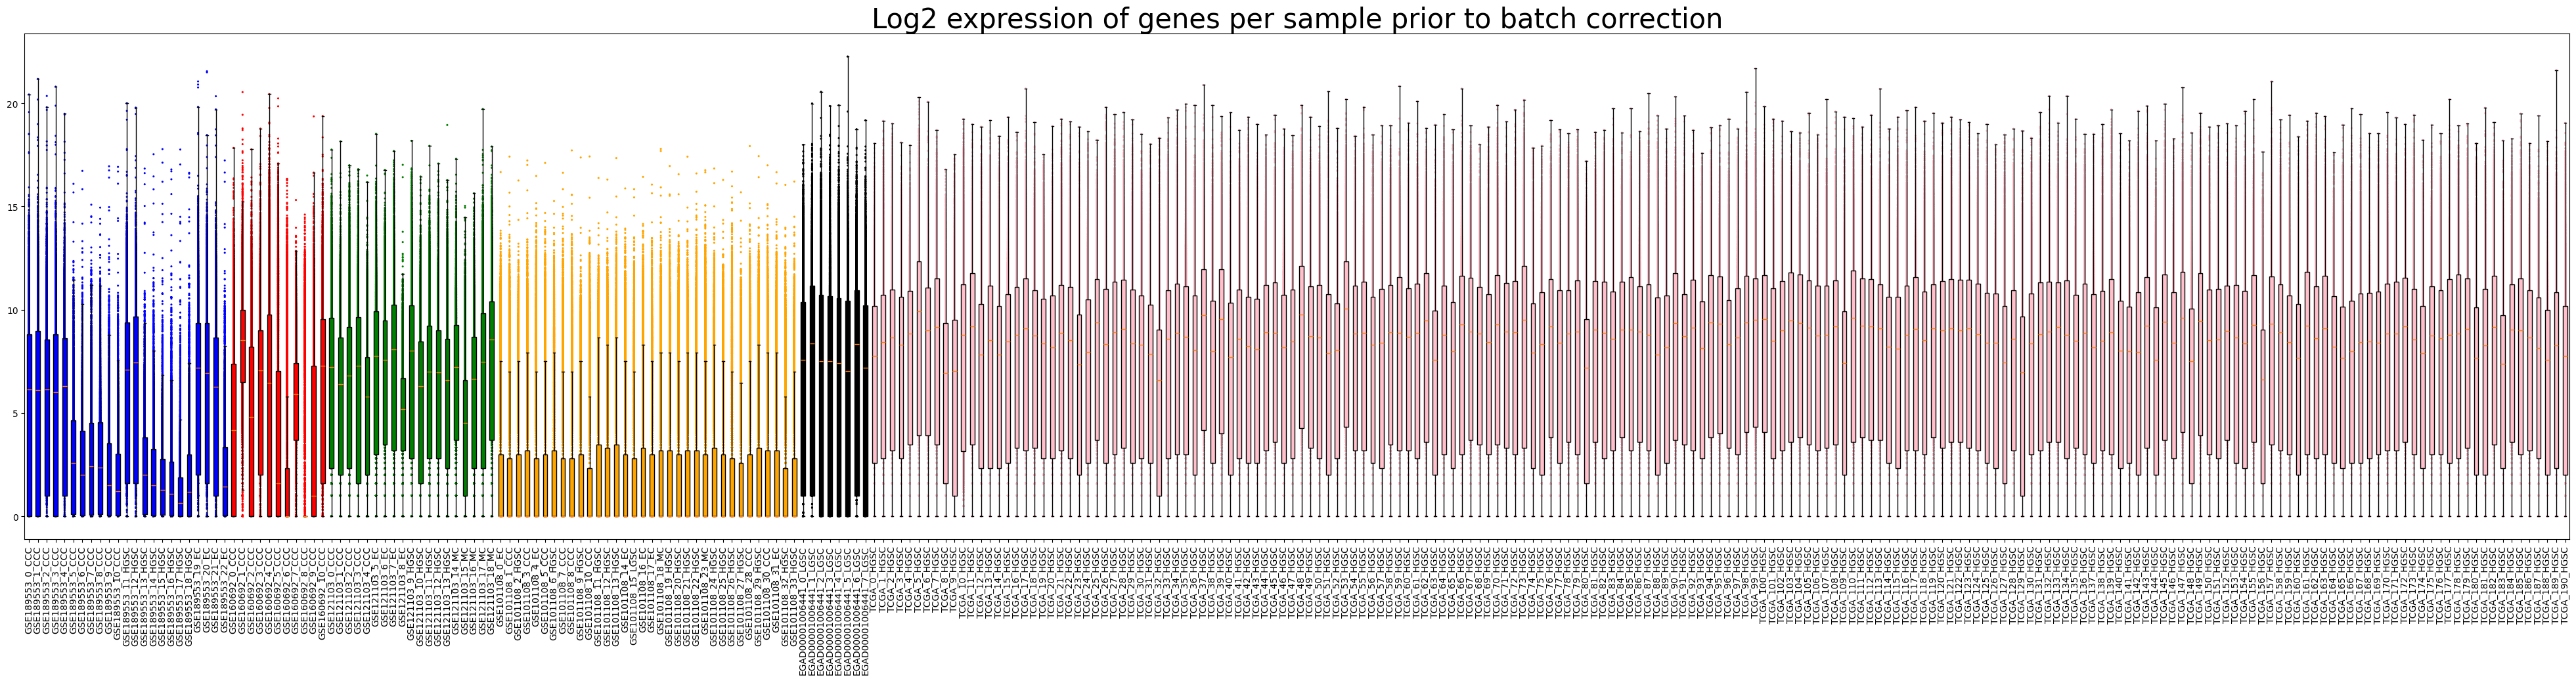

In [20]:
boxplot(log2_expression_df, "Log2 expression of genes per sample prior to batch correction")

### UMAP of log2 transformed counts prior to batch correction

/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_28031/3290048524.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)


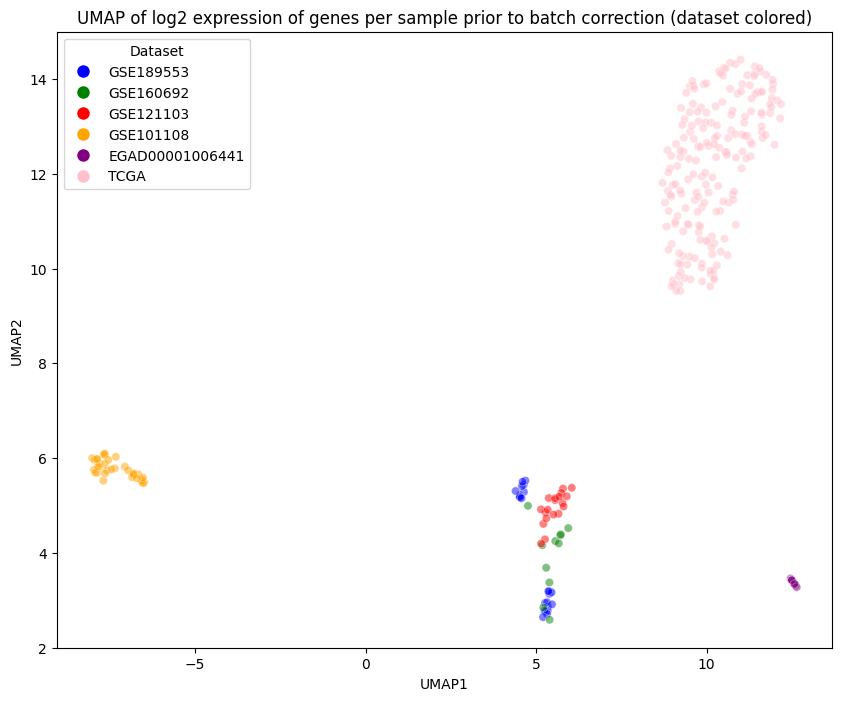

/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_28031/3290048524.py:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)


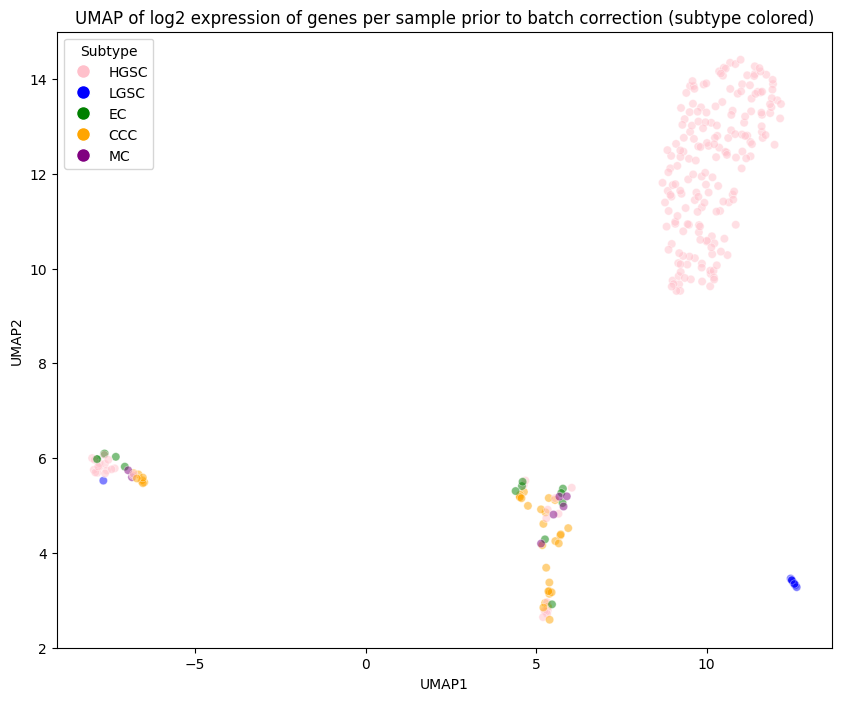

In [21]:
plot_umap(log2_expression_df, metadata, "UMAP of log2 expression of genes per sample prior to batch correction")

## Run pyComBat batch correction

In [23]:
# Remove genes with zero variance (due to bug in PyCombat: https://github.com/epigenelabs/pyComBat/issues/27)
log2_expression_df = log2_expression_df.loc[log2_expression_df.var(axis=1) > 0]

batch_labels = log2_expression_df.columns.map(lambda x: x.split("_")[0])
log2_expression_corrected = pycombat(log2_expression_df, batch_labels)

display(log2_expression_corrected)

Found 6 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


,GSE189553_0_CCC,GSE189553_1_CCC,GSE189553_2_CCC,GSE189553_3_CCC,GSE189553_4_CCC,GSE189553_5_CCC,GSE189553_6_CCC,GSE189553_7_CCC,GSE189553_8_CCC,GSE189553_9_CCC,...,TCGA_181_HGSC,TCGA_182_HGSC,TCGA_183_HGSC,TCGA_184_HGSC,TCGA_185_HGSC,TCGA_186_HGSC,TCGA_187_HGSC,TCGA_188_HGSC,TCGA_189_HGSC,TCGA_190_HGSC
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,4.122937,5.883753,5.831331,4.394744,5.644835,3.681420,2.840510,3.679833,3.322955,3.799734,...,3.254216,3.754061,3.134342,6.442935,5.955369,4.458552,2.549725,3.134342,4.141770,3.134342
A1BG-AS1,7.387870,7.839300,7.548118,6.832878,7.861041,5.779067,5.544747,5.520662,5.273778,5.428649,...,6.747890,6.097621,5.052058,8.171099,7.962104,7.038643,5.266264,3.006684,4.745702,3.604918
A2M,12.213694,12.159004,12.210468,12.492652,11.857448,10.594928,10.074944,10.248318,10.115582,9.725099,...,10.949842,11.240991,10.117529,11.261642,10.915668,11.121034,11.382500,10.564207,10.794503,11.821429
A2M-AS1,6.011196,6.178525,6.414363,6.363753,5.775358,5.260298,5.094143,5.351468,5.197054,5.040111,...,4.352376,7.533386,5.410794,5.423461,4.754614,6.729886,6.758821,4.458150,4.483368,5.889498
A2ML1,6.009492,6.009492,6.009492,5.840835,6.399730,3.902133,4.352881,3.923378,4.133326,3.912807,...,7.177337,6.537257,1.515714,7.881411,7.516020,6.236742,2.976486,2.194934,2.734061,7.006935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,10.088209,10.154263,9.979139,9.893733,10.021640,8.310939,8.247366,8.520441,8.406815,8.142466,...,8.873333,9.976957,7.958378,9.194734,9.229315,9.360761,8.707638,8.198504,8.239014,7.932250
ZYG11A,7.828392,7.820439,6.430506,7.066129,8.597022,4.455305,3.924355,3.405645,3.456144,4.023649,...,7.024180,6.003934,3.176957,8.016585,3.101297,4.522206,3.623071,3.566675,5.484545,1.680389
ZYG11B,10.880106,11.173522,10.818639,11.064375,10.969076,8.607483,8.431452,8.572126,8.709610,8.348616,...,9.509132,10.452967,8.266867,10.957899,9.687386,8.934163,9.037744,8.128231,9.230239,8.658713


### Sanity check and adjust pycombat results

In [24]:
expression_corrected = log2_expression_corrected.applymap(lambda x: 2 ** x - 1)
# Round expression_corrected counts to nearest integer
expression_corrected = expression_corrected.round().astype(int)

assert(expression_corrected.isnull().sum().sum() == 0)

# Count the number of genes that have negative expression values
num_neg_genes = expression_corrected[(expression_corrected < 0).any(axis=1)].shape[0]
print(f"Number of genes with negative expression values: {num_neg_genes} out of {expression_corrected.shape[0]} total genes")
num_neg_entries = (expression_corrected < 0).sum().sum()
print(f"Number of entries with negative expression values: {num_neg_entries} out of {expression_corrected.shape[0] * expression_corrected.shape[1]} total values")

# Set negative expression values to 0
# expression_corrected.loc["A1BG", "TCGA_142_HGSC"] is an example of a gene that ends up with negative expression values
# it has 0 expression in the original data, but the batch correction process introduces negative values
expression_corrected[expression_corrected < 0] = 0

expression_corrected.to_csv(pycombat_batch_corrected_counts_path, sep="\t")
display(expression_corrected)

Number of genes with negative expression values: 643 out of 19542 total genes
Number of entries with negative expression values: 1173 out of 5589012 total values


,GSE189553_0_CCC,GSE189553_1_CCC,GSE189553_2_CCC,GSE189553_3_CCC,GSE189553_4_CCC,GSE189553_5_CCC,GSE189553_6_CCC,GSE189553_7_CCC,GSE189553_8_CCC,GSE189553_9_CCC,...,TCGA_181_HGSC,TCGA_182_HGSC,TCGA_183_HGSC,TCGA_184_HGSC,TCGA_185_HGSC,TCGA_186_HGSC,TCGA_187_HGSC,TCGA_188_HGSC,TCGA_189_HGSC,TCGA_190_HGSC
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,16,58,56,20,49,12,6,12,9,13,...,9,12,8,86,61,21,5,8,17,8
A1BG-AS1,166,228,186,113,231,54,46,45,38,42,...,106,67,32,287,248,130,37,7,26,11
A2M,4749,4572,4738,5762,3710,1546,1078,1215,1108,845,...,1977,2419,1110,2454,1931,2226,2669,1513,1775,3618
A2M-AS1,63,71,84,81,54,37,33,40,36,32,...,19,184,42,42,26,105,107,21,21,58
A2ML1,63,63,63,56,83,14,19,14,17,14,...,144,92,2,235,182,74,7,4,6,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,1088,1139,1008,950,1038,317,303,366,338,282,...,468,1007,248,585,599,656,417,293,301,243
ZYG11A,226,225,85,133,386,21,14,10,10,15,...,129,63,8,258,8,22,11,11,44,2
ZYG11B,1884,2309,1805,2140,2004,389,344,380,418,325,...,728,1401,307,1988,824,488,525,279,600,403


### Boxplot of corrected log transformed counts

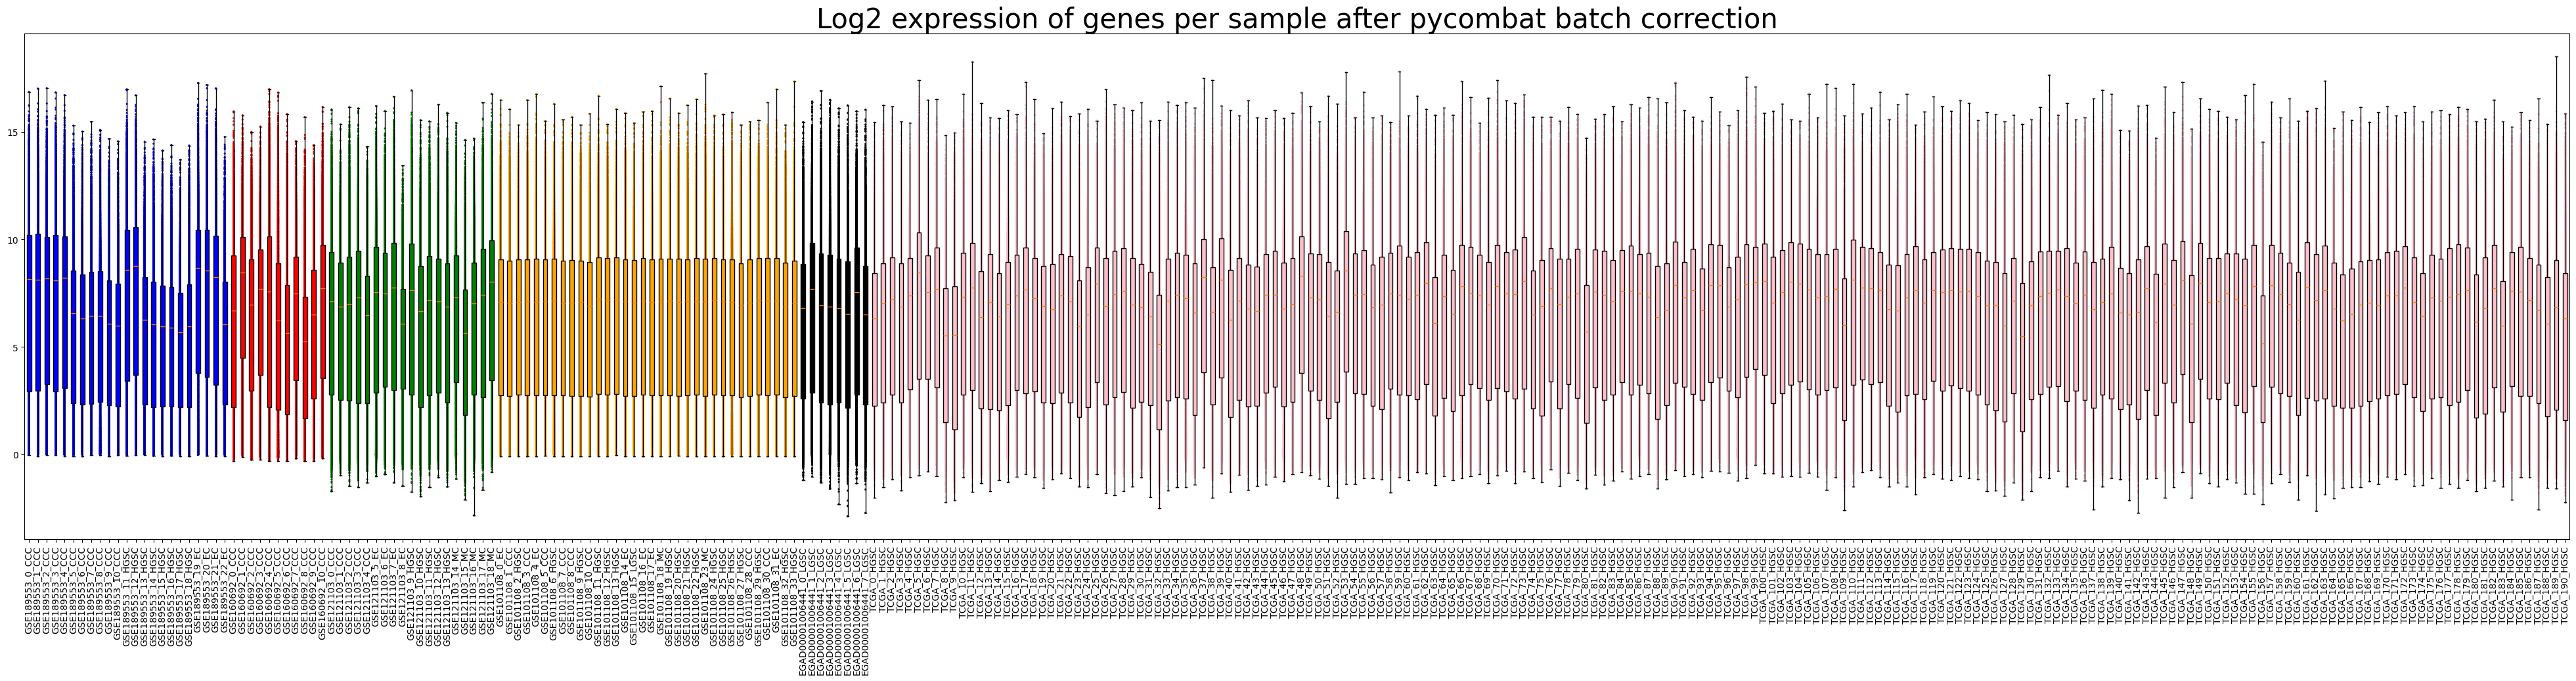

In [25]:
boxplot(log2_expression_corrected, "Log2 expression of genes per sample after pycombat batch correction")

### UMAP after PyComBat correction

/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_28031/3290048524.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)


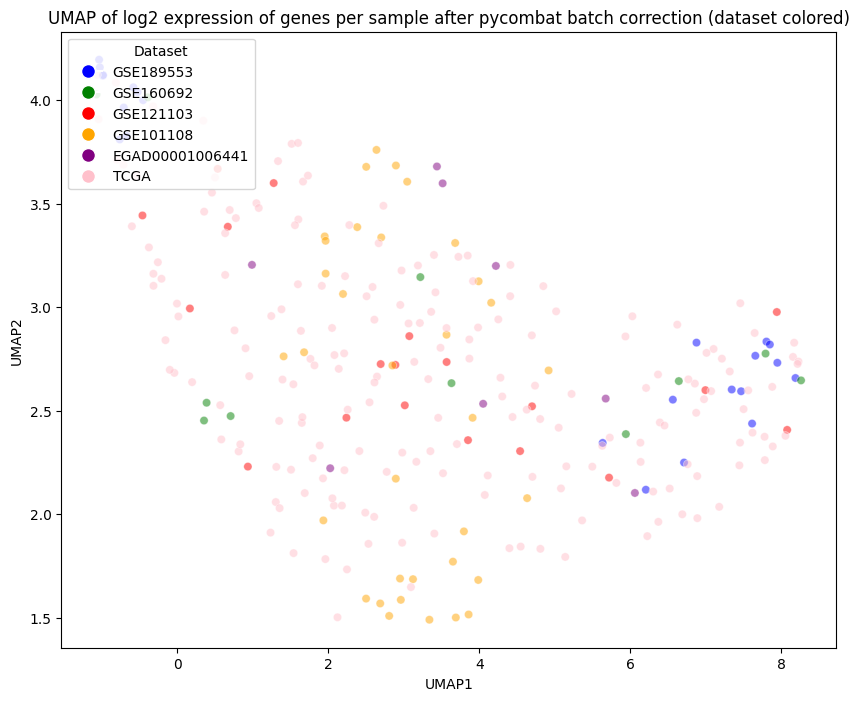

/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_28031/3290048524.py:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)


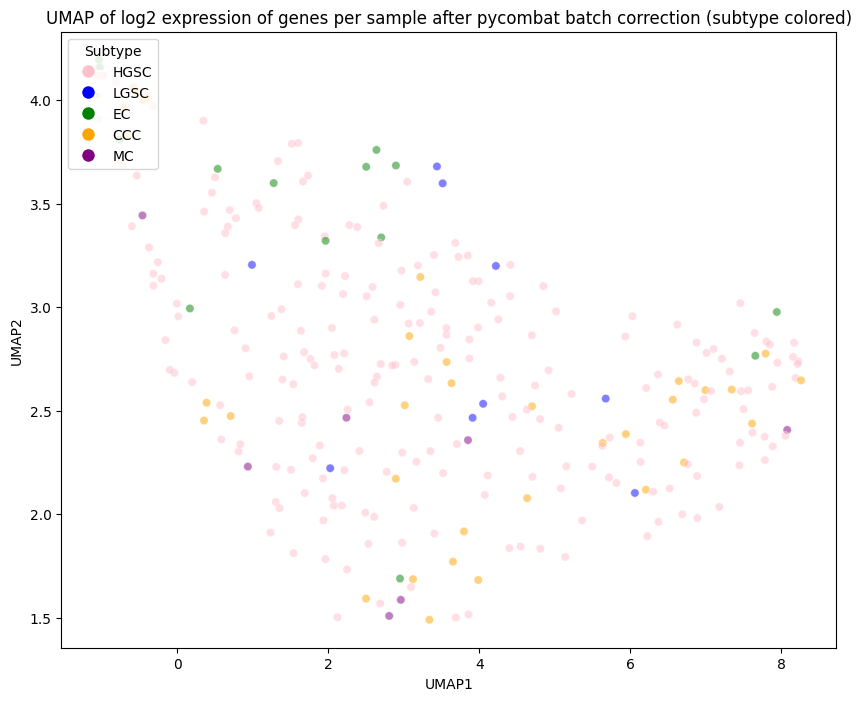

In [26]:
plot_umap(log2_expression_corrected, metadata, "UMAP of log2 expression of genes per sample after pycombat batch correction")

## Use PyCombat to merge just the celllines (leaving out TCGA data)

This will be useful for the Celligner batch correction.

In [27]:
cellline_datasets = ["GSE189553", "GSE160692", "GSE121103", "GSE101108", "EGAD00001006441"]

# merge all the cellline datasets into one, keeping the common genes only
expression_celllines_df = pd.concat(
    [
        dataset_gse189553,
        dataset_gse160692,
        dataset_gse121103,
        dataset_gse101108,
        dataset_egad00001006441,
    ], join="inner", axis=1)

metadata_celllines = metadata[metadata['dataset_name'].isin(cellline_datasets)]

# pycombat needs the log2 transformed data
log2_expression_celllines_df = expression_celllines_df.applymap(lambda x: np.log2(x + 1))

### Plots prior to correction (celllines only)

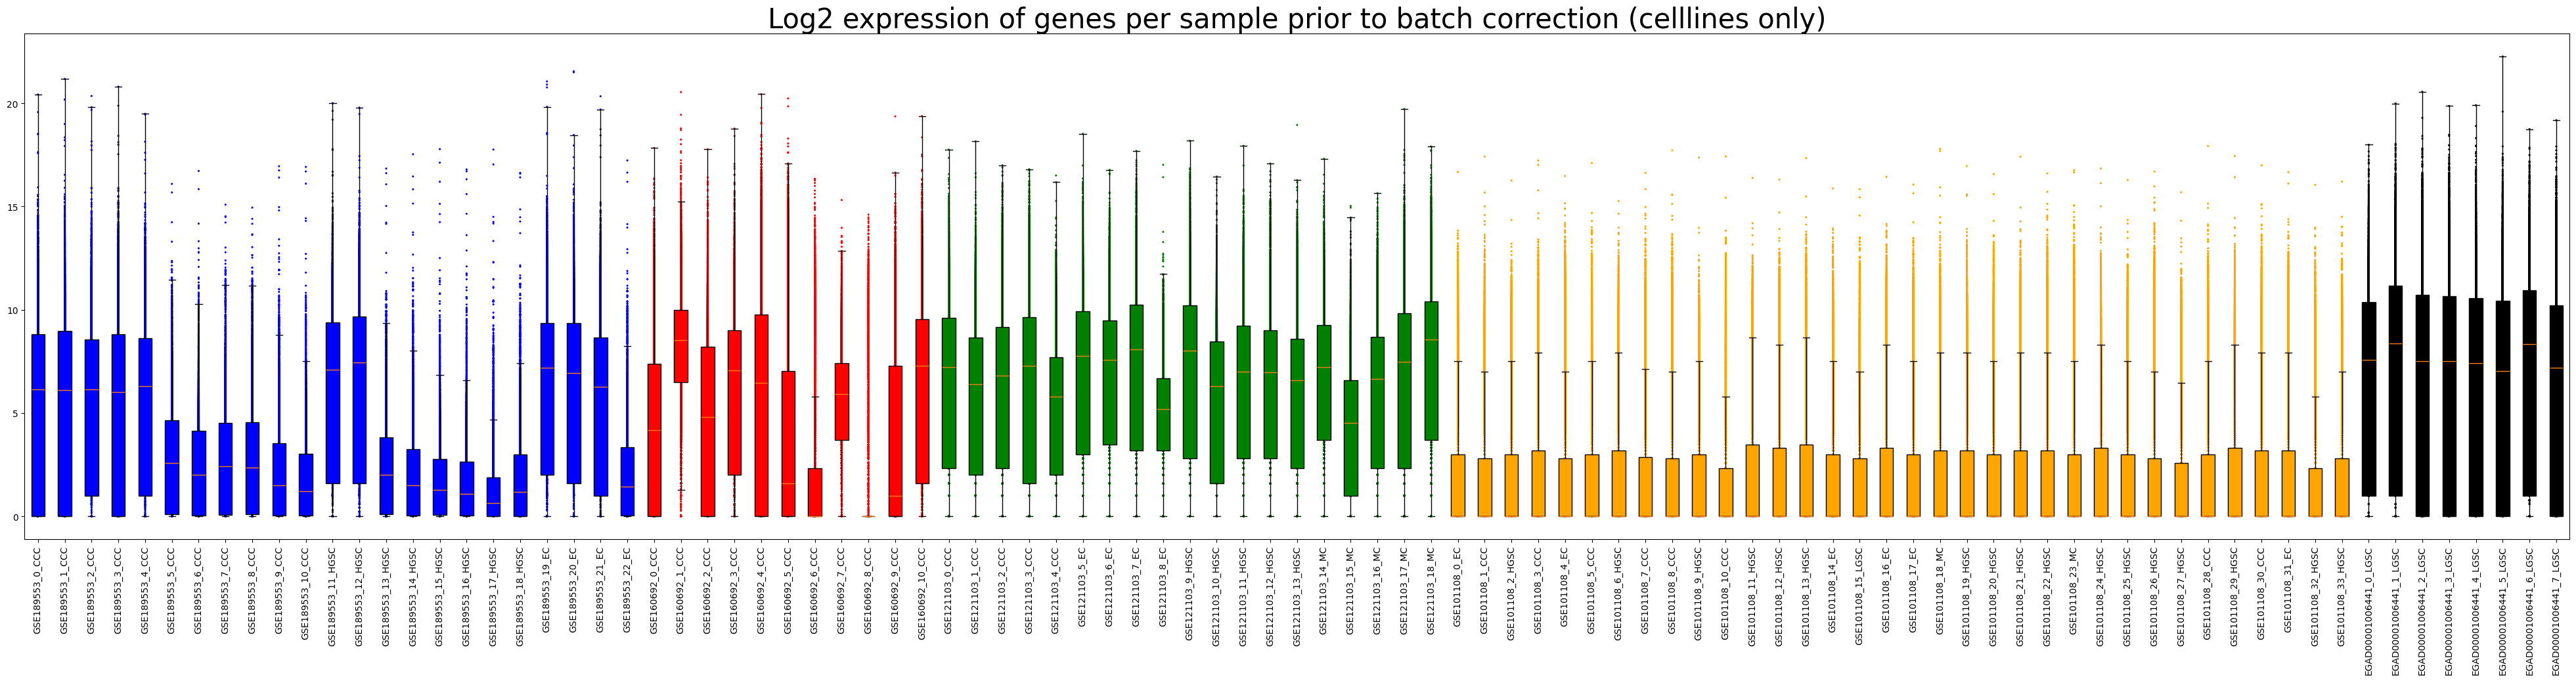

In [28]:
boxplot(log2_expression_celllines_df, "Log2 expression of genes per sample prior to batch correction (celllines only)")

In [29]:
display(metadata_celllines.index[~metadata_celllines.index.isin(log2_expression_celllines_df.columns)])
display(log2_expression_celllines_df.columns[~log2_expression_celllines_df.columns.isin(metadata_celllines.index)])


Index([], dtype='object', name='sample_id')

Index([], dtype='object')

/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_28031/3290048524.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)


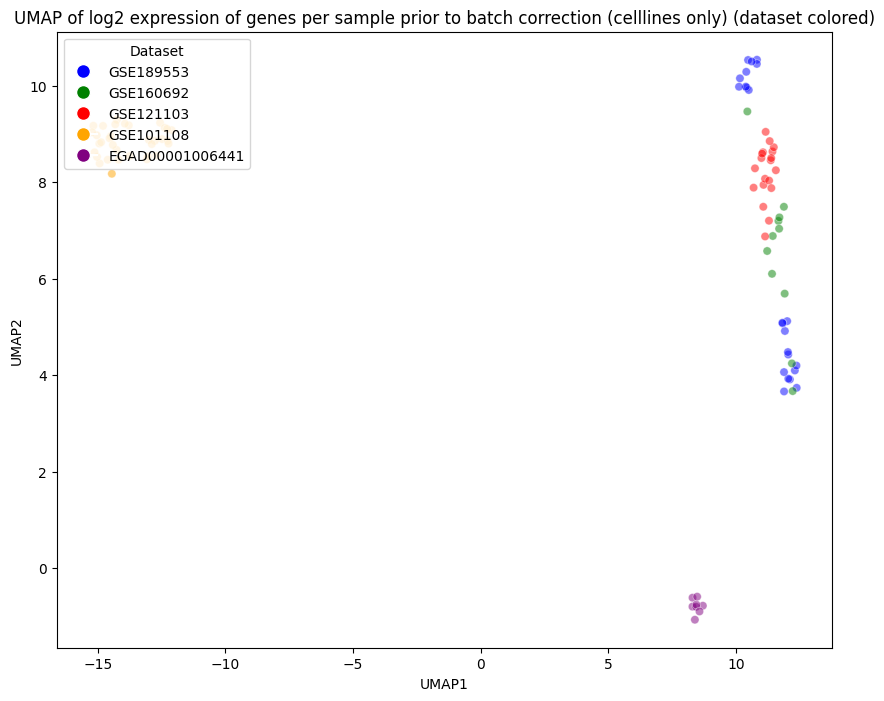

/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_28031/3290048524.py:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)


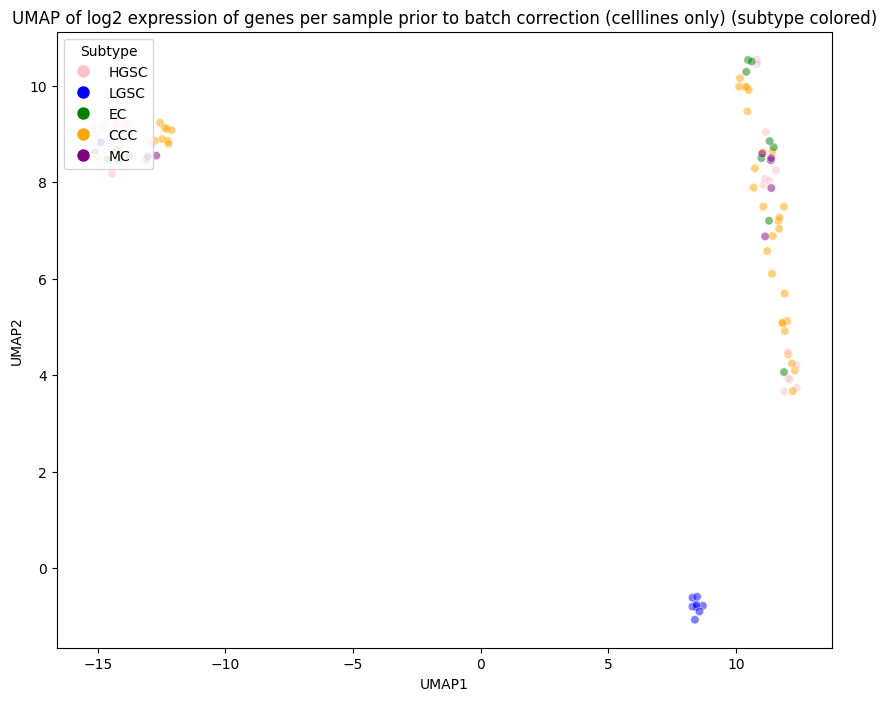

In [30]:
plot_umap(log2_expression_celllines_df, metadata_celllines, "UMAP of log2 expression of genes per sample prior to batch correction (celllines only)")

In [31]:
# Check that there are no NaN values in log2_expression_df
assert log2_expression_celllines_df.isnull().sum().sum() == 0

# Remove genes with zero variance (due to bug in PyCombat: https://github.com/epigenelabs/pyComBat/issues/27)
log2_expression_celllines_df = log2_expression_celllines_df.loc[log2_expression_celllines_df.var(axis=1) > 0]

batch_labels_celllines = expression_celllines_df.columns.map(lambda x: x.split("_")[0])
log2_expression_celllines_corrected = pycombat(log2_expression_celllines_df, batch_labels_celllines)

expression_celllines_corrected = log2_expression_celllines_corrected.applymap(lambda x: 2 ** x - 1)

# Save the batch corrected data
expression_celllines_corrected.to_csv(pycombat_batch_corrected_counts_celllines_only_path, sep="\t")

/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Found 5 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


### Plots after pycombat correction (celllines only)

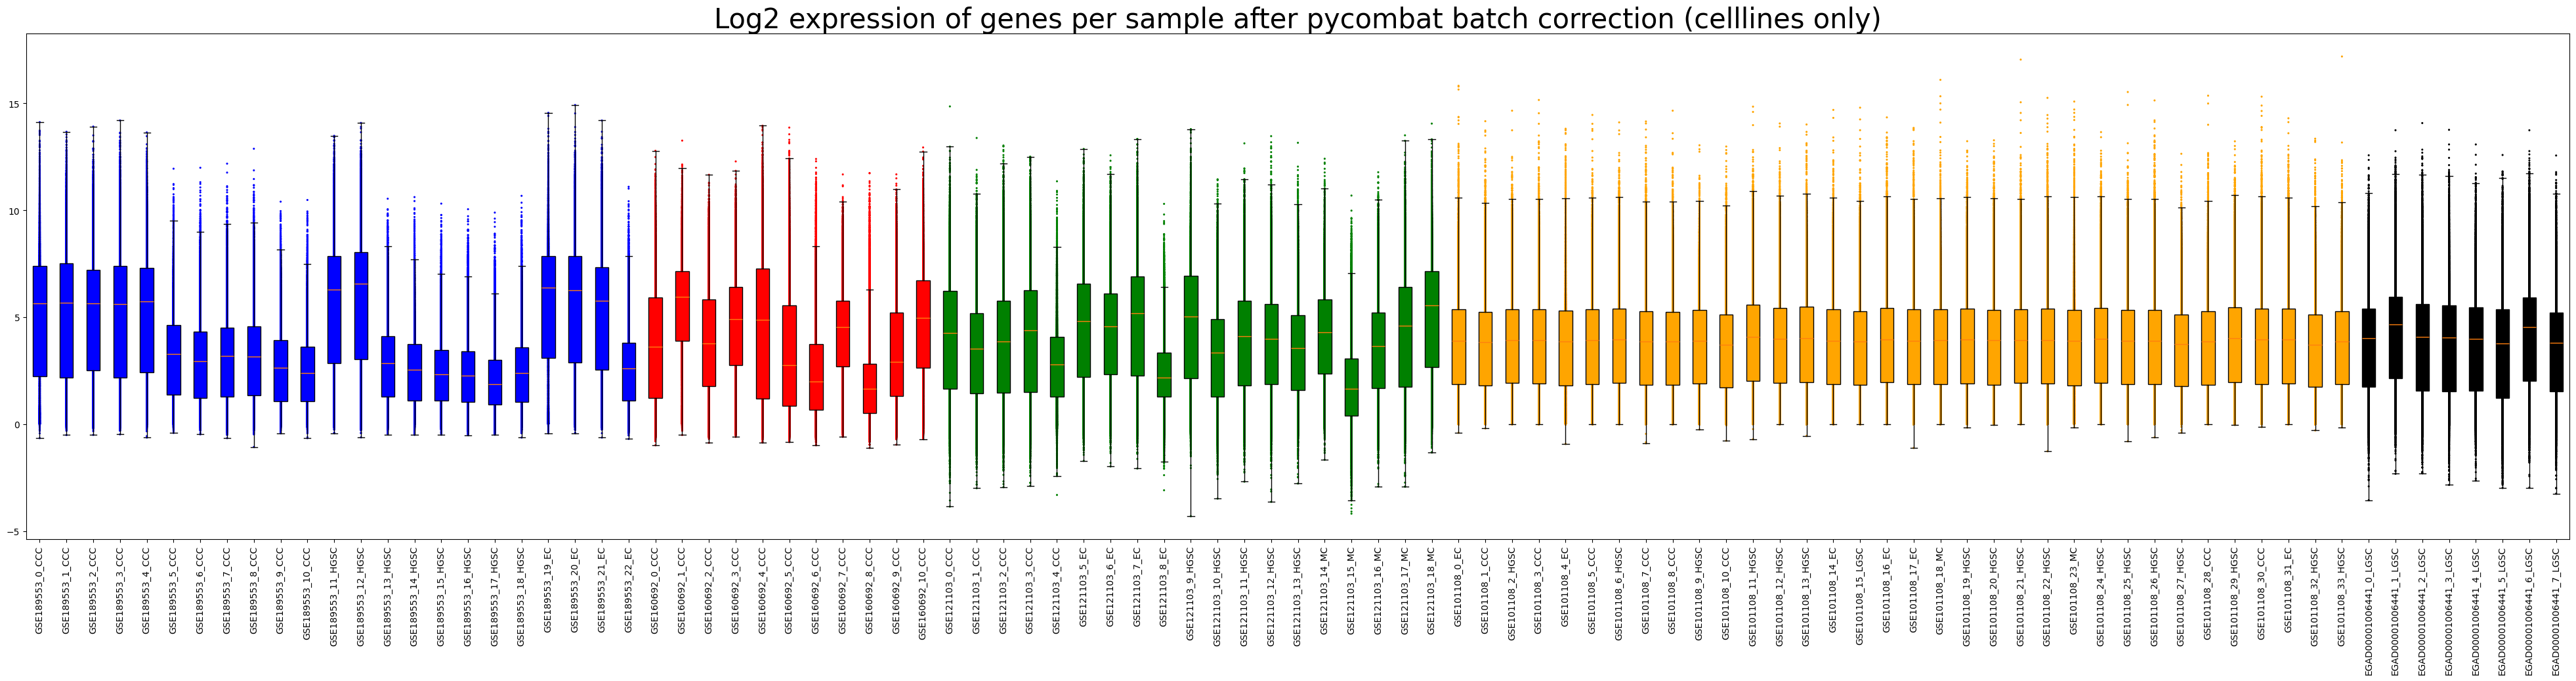

In [32]:
boxplot(log2_expression_celllines_corrected, "Log2 expression of genes per sample after pycombat batch correction (celllines only)")

/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_28031/3290048524.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)


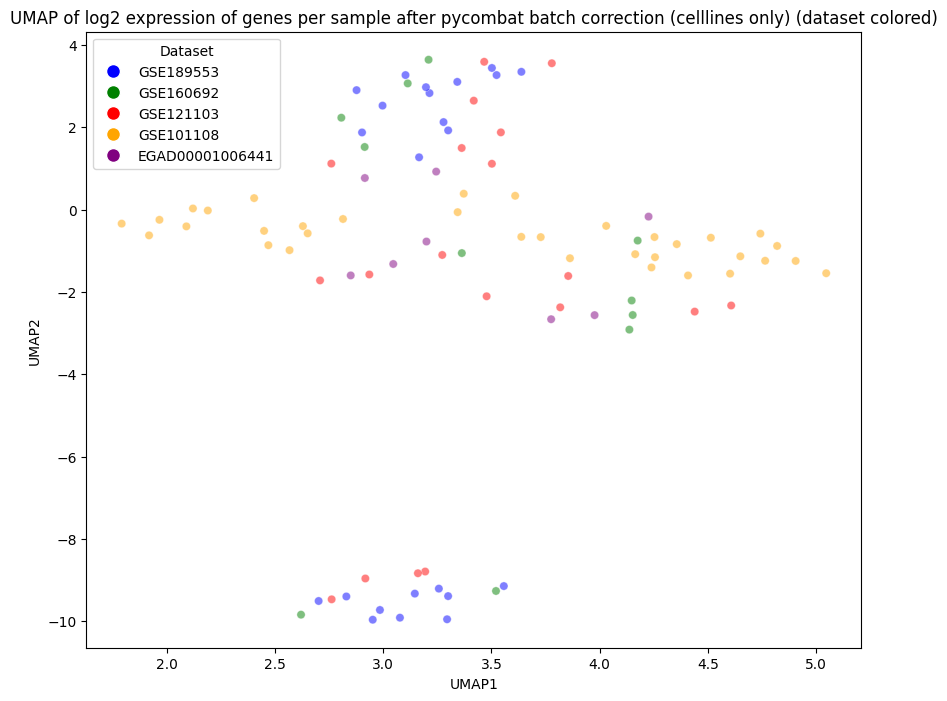

/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_28031/3290048524.py:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)


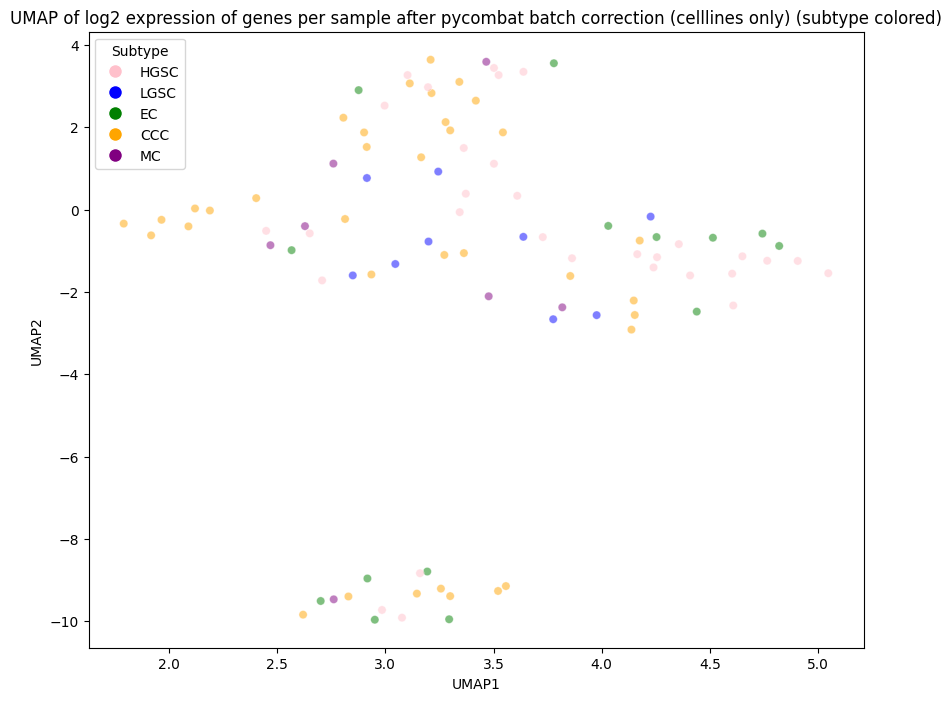

In [33]:
plot_umap(log2_expression_celllines_corrected, metadata_celllines, "UMAP of log2 expression of genes per sample after pycombat batch correction (celllines only)")

## Use PyCombat to merge based on all TCGA cancer types

We are hoping that this will merge the datasets based on differences in batches rather than differences in ovarian cancer tyhpe (since TCGA is mostly one ovarian cancer type)

### Combine datasets

In [6]:
# merge all the datasets into one, keeping the common genes only
expression_df = pd.concat(
    [
        dataset_gse189553,
        dataset_gse160692,
        dataset_gse121103,
        dataset_gse101108,
        dataset_egad00001006441,
        dataset_tcga,
        dataset_tcga_all_cancer_types
    ], join="inner", axis=1)

display(expression_df)

# pycombat needs the log2 transformed data
log2_expression_df = expression_df.applymap(lambda x: np.log2(x + 1))
display(log2_expression_df)

,GSE189553_0_CCC,GSE189553_1_CCC,GSE189553_2_CCC,GSE189553_3_CCC,GSE189553_4_CCC,GSE189553_5_CCC,GSE189553_6_CCC,GSE189553_7_CCC,GSE189553_8_CCC,GSE189553_9_CCC,...,TCGA_9851_non_ovarian,TCGA_9852_non_ovarian,TCGA_9853_non_ovarian,TCGA_9854_non_ovarian,TCGA_9855_non_ovarian,TCGA_9856_non_ovarian,TCGA_9857_non_ovarian,TCGA_9858_non_ovarian,TCGA_9859_non_ovarian,TCGA_9860_non_ovarian
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,9.0,53.72,51.02,12.00,42.45,5.53,1.90,5.52,3.62,6.32,...,5.0,22.0,2.0,7.0,3.0,11.0,16.0,14.0,3.582576,3.0
A1BG-AS1,38.0,69.00,47.00,18.00,71.00,3.85,2.58,2.47,1.52,2.08,...,54.0,122.0,1.0,63.0,1.0,68.0,163.0,43.0,19.784610,14.0
A2M,1716.0,1584.98,1707.98,2572.98,1022.81,162.84,76.03,98.07,80.71,45.36,...,13915.0,8453.0,2698.0,11177.0,7305.0,10616.0,6299.0,9803.0,7542.096446,10631.0
A2M-AS1,5.0,7.00,11.00,10.00,3.00,0.65,0.24,0.93,0.48,0.13,...,20.0,22.0,12.0,19.0,7.0,12.0,13.0,32.0,48.193496,11.0
A2ML1,6.0,6.00,6.00,5.00,9.00,0.02,0.54,0.04,0.26,0.03,...,7636.0,6421.0,6800.0,10189.0,299.0,3334.0,3762.0,24452.0,28431.280862,2119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,389.0,442.00,315.00,267.00,342.00,11.65,10.19,17.95,14.22,8.14,...,1239.0,924.0,1980.0,2468.0,210.0,1248.0,1416.0,1425.0,2086.298254,1216.0
ZYG11A,118.0,117.00,26.00,52.00,268.00,2.32,0.89,0.09,0.15,1.10,...,6.0,31.0,33.0,54.0,144.0,7.0,3.0,1052.0,30.320920,55.0
ZYG11B,1085.0,1852.00,970.00,1518.00,1276.00,16.32,11.57,15.24,19.86,9.81,...,836.0,1149.0,1236.0,1081.0,183.0,895.0,1644.0,1258.0,2497.988595,1231.0


/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_59391/3194193979.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log2_expression_df = expression_df.applymap(lambda x: np.log2(x + 1))


,GSE189553_0_CCC,GSE189553_1_CCC,GSE189553_2_CCC,GSE189553_3_CCC,GSE189553_4_CCC,GSE189553_5_CCC,GSE189553_6_CCC,GSE189553_7_CCC,GSE189553_8_CCC,GSE189553_9_CCC,...,TCGA_9851_non_ovarian,TCGA_9852_non_ovarian,TCGA_9853_non_ovarian,TCGA_9854_non_ovarian,TCGA_9855_non_ovarian,TCGA_9856_non_ovarian,TCGA_9857_non_ovarian,TCGA_9858_non_ovarian,TCGA_9859_non_ovarian,TCGA_9860_non_ovarian
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,3.321928,5.773996,5.700994,3.700440,5.441284,2.707083,1.536053,2.704872,2.207893,2.871844,...,2.584963,4.523562,1.584963,3.000000,2.000000,3.584963,4.087463,3.906891,2.196159,2.000000
A1BG-AS1,5.285402,6.129283,5.584963,4.247928,6.169925,2.277985,1.839960,1.794936,1.333424,1.622930,...,5.781360,6.942515,1.000000,6.000000,1.000000,6.108524,7.357552,5.459432,4.377444,3.906891
A2M,10.745674,10.631159,10.738920,11.329785,9.999732,7.356144,6.267349,6.630376,6.352441,5.534809,...,13.764457,13.045418,11.398209,13.448374,12.834866,13.374089,12.621136,13.259155,12.880941,13.376125
A2M-AS1,2.584963,3.000000,3.584963,3.459432,2.000000,0.722466,0.310340,0.948601,0.565597,0.176323,...,4.392317,4.523562,3.700440,4.321928,3.000000,3.700440,3.807355,5.044394,5.620396,3.584963
A2ML1,2.807355,2.807355,2.807355,2.584963,3.321928,0.028569,0.622930,0.056584,0.333424,0.042644,...,12.898790,12.648807,12.731531,13.314866,8.228819,11.703471,11.877668,14.577724,14.795242,11.049849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,8.607330,8.791163,8.303781,8.066089,8.422065,3.661065,3.484138,4.244126,3.927896,3.192194,...,10.276124,9.853310,10.952013,11.269711,7.721099,10.286558,10.468624,10.477758,11.027421,10.249113
ZYG11A,6.894818,6.882643,4.754888,5.727920,8.071462,1.731183,0.918386,0.124328,0.201634,1.070389,...,2.807355,5.000000,5.087463,5.781360,7.179909,3.000000,2.000000,10.040290,4.969055,5.807355
ZYG11B,10.084808,10.855647,9.923327,10.568906,10.318543,4.114367,3.651913,4.021480,4.382667,3.434295,...,9.709084,10.167418,10.272630,10.079485,7.523562,9.807355,10.683872,10.298063,11.287129,10.266787


### Clean up data

In [7]:
# Check that there are no NaN values in log2_expression_df
assert log2_expression_df.isnull().sum().sum() == 0

# Check that all expression values are nonnegative
assert (expression_df < 0).sum().sum() == 0

### Boxplot of log2 counts prior to correction

In [ ]:
boxplot(log2_expression_df, "Log2 expression of genes per sample prior to batch correction")

### UMAP of log2 counts prior to correction

In [ ]:
plot_umap(log2_expression_df, metadata_with_tcga_all_cancer_types, "UMAP of log2 expression of genes per sample prior to batch correction")

### Run pycombat batch correction

In [8]:
# Remove genes with zero variance (due to bug in PyCombat: https://github.com/epigenelabs/pyComBat/issues/27)
log2_expression_df = log2_expression_df.loc[log2_expression_df.var(axis=1) > 0]

batch_labels = log2_expression_df.columns.map(lambda x: x.split("_")[0])
log2_expression_corrected = pycombat(log2_expression_df, batch_labels)

display(log2_expression_corrected)

Found 6 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


,GSE189553_0_CCC,GSE189553_1_CCC,GSE189553_2_CCC,GSE189553_3_CCC,GSE189553_4_CCC,GSE189553_5_CCC,GSE189553_6_CCC,GSE189553_7_CCC,GSE189553_8_CCC,GSE189553_9_CCC,...,TCGA_9851_non_ovarian,TCGA_9852_non_ovarian,TCGA_9853_non_ovarian,TCGA_9854_non_ovarian,TCGA_9855_non_ovarian,TCGA_9856_non_ovarian,TCGA_9857_non_ovarian,TCGA_9858_non_ovarian,TCGA_9859_non_ovarian,TCGA_9860_non_ovarian
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,4.642651,6.855779,6.789891,4.984279,6.555488,4.087719,3.030799,4.085724,3.637172,4.236425,...,2.569615,4.506494,1.570502,2.984284,1.985171,3.568727,4.070782,3.890370,2.181156,1.985171
A1BG-AS1,7.284288,7.721349,7.439436,6.746961,7.742398,5.726692,5.499831,5.476513,5.237487,5.387428,...,5.781385,6.945190,0.989115,6.000525,0.989115,6.109297,7.361174,5.458723,4.374266,3.902639
A2M,15.147553,15.110762,15.145383,15.335212,14.907901,14.058586,13.708784,13.825416,13.736122,13.473438,...,13.681768,12.962031,11.313223,13.365379,12.751275,13.291021,12.537337,13.175975,12.797394,13.293060
A2M-AS1,5.921420,6.103093,6.359147,6.304199,5.665365,5.106153,4.925754,5.205138,5.037487,4.867091,...,4.365885,4.497330,3.672952,4.295388,2.971444,3.672952,3.780031,5.018956,5.595836,3.557299
A2ML1,6.828482,6.828482,6.828482,6.584977,7.391905,3.785894,4.436681,3.816568,4.119690,3.801306,...,12.841767,12.592614,12.675063,13.256461,8.187310,11.650419,11.824037,14.515123,14.731918,10.998968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,10.980697,11.010946,10.930750,10.891639,10.950213,10.166820,10.137708,10.262759,10.210726,10.089671,...,10.219685,9.787399,10.910713,11.235527,7.607430,10.230352,10.416496,10.425835,10.987810,10.192069
ZYG11A,8.193598,8.183452,6.410251,7.221145,9.174175,3.890396,3.213038,2.551296,2.615720,3.339712,...,2.790801,4.980350,5.067690,5.760607,7.157182,2.983174,1.984586,10.013525,4.949449,5.786566
ZYG11B,11.579841,11.741462,11.545983,11.681341,11.628848,10.328017,10.231054,10.308541,10.384271,10.185426,...,9.646409,10.113078,10.220203,10.023545,7.421144,9.746467,10.638923,10.246098,11.253150,10.214253


### Sanity check and adjust pycombat results

In [23]:
expression_corrected = log2_expression_corrected.applymap(lambda x: 2 ** x - 1)
# Round expression_corrected counts to nearest integer
expression_corrected = expression_corrected.round().astype(int)

assert(expression_corrected.isnull().sum().sum() == 0)

# Count the number of genes that have negative expression values
num_neg_genes = expression_corrected[(expression_corrected < 0).any(axis=1)].shape[0]
print(f"Number of genes with negative expression values: {num_neg_genes} out of {expression_corrected.shape[0]} total genes")
num_neg_entries = (expression_corrected < 0).sum().sum()
print(f"Number of entries with negative expression values: {num_neg_entries} out of {expression_corrected.shape[0] * expression_corrected.shape[1]} total values")

# Set negative expression values to 0
expression_corrected[expression_corrected < 0] = 0

display(expression_corrected)

# Remove non-ovarian cancer types
expression_corrected_ov_only = expression_corrected.loc[:, metadata_with_tcga_all_cancer_types[metadata_with_tcga_all_cancer_types['type'] != 'non_ovarian'].index]
log2_expression_corrected_ov_only = log2_expression_corrected.loc[:, metadata_with_tcga_all_cancer_types[metadata_with_tcga_all_cancer_types['type'] != 'non_ovarian'].index]
display(expression_corrected_ov_only)
expression_corrected_ov_only.to_csv(pycombat_batch_corrected_counts_used_all_cancer_types_path)

/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_59391/1173370881.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  expression_corrected = log2_expression_corrected.applymap(lambda x: 2 ** x - 1)


Number of genes with negative expression values: 238 out of 19562 total genes
Number of entries with negative expression values: 355 out of 198495614 total values


,GSE189553_0_CCC,GSE189553_1_CCC,GSE189553_2_CCC,GSE189553_3_CCC,GSE189553_4_CCC,GSE189553_5_CCC,GSE189553_6_CCC,GSE189553_7_CCC,GSE189553_8_CCC,GSE189553_9_CCC,...,TCGA_9851_non_ovarian,TCGA_9852_non_ovarian,TCGA_9853_non_ovarian,TCGA_9854_non_ovarian,TCGA_9855_non_ovarian,TCGA_9856_non_ovarian,TCGA_9857_non_ovarian,TCGA_9858_non_ovarian,TCGA_9859_non_ovarian,TCGA_9860_non_ovarian
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,24,115,110,31,93,16,7,16,11,18,...,5,22,2,7,3,11,16,14,4,3
A1BG-AS1,155,210,173,106,213,52,44,44,37,41,...,54,122,1,63,1,68,163,43,20,14
A2M,36296,35382,36241,41338,30741,17062,13388,14516,13644,11373,...,13140,7978,2544,10552,6894,10022,5943,9254,7118,10036
A2M-AS1,60,68,81,78,50,33,29,36,32,28,...,20,22,12,19,7,12,13,31,47,11
A2ML1,113,113,113,95,167,13,21,13,16,13,...,7340,6176,6539,9785,290,3214,3625,23414,27210,2046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,2020,2063,1951,1899,1978,1149,1126,1228,1184,1089,...,1191,883,1924,2410,194,1200,1366,1375,2030,1169
ZYG11A,292,290,84,148,577,14,8,5,5,9,...,6,31,33,53,142,7,3,1033,30,54
ZYG11B,3060,3423,2989,3283,3166,1284,1201,1267,1336,1163,...,800,1106,1192,1040,170,858,1594,1213,2440,1187


sample_id,GSE189553_0_CCC,GSE189553_1_CCC,GSE189553_2_CCC,GSE189553_3_CCC,GSE189553_4_CCC,GSE189553_5_CCC,GSE189553_6_CCC,GSE189553_7_CCC,GSE189553_8_CCC,GSE189553_9_CCC,...,TCGA_181_HGSC,TCGA_182_HGSC,TCGA_183_HGSC,TCGA_184_HGSC,TCGA_185_HGSC,TCGA_186_HGSC,TCGA_187_HGSC,TCGA_188_HGSC,TCGA_189_HGSC,TCGA_190_HGSC
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,24,115,110,31,93,16,7,16,11,18,...,14,19,13,92,69,29,9,13,24,13
A1BG-AS1,155,210,173,106,213,52,44,44,37,41,...,100,64,31,265,230,122,36,7,25,11
A2M,36296,35382,36241,41338,30741,17062,13388,14516,13644,11373,...,12043,16657,4765,17045,11594,14574,19501,7837,10130,31799
A2M-AS1,60,68,81,78,50,33,29,36,32,28,...,48,498,105,106,65,277,283,52,53,150
A2ML1,113,113,113,95,167,13,21,13,16,13,...,411,254,5,697,529,202,17,9,14,361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,2020,2063,1951,1899,1978,1149,1126,1228,1184,1089,...,1739,4427,801,2282,2350,2627,1511,981,1016,783
ZYG11A,292,290,84,148,577,14,8,5,5,9,...,246,127,20,467,19,48,27,26,91,7
ZYG11B,3060,3423,2989,3283,3166,1284,1201,1267,1336,1163,...,2111,3744,993,5087,2352,1489,1586,913,1782,1260


### Boxplot after pycombat correction

In [ ]:
boxplot(log2_expression_corrected, "Log2 expression of genes per sample after pycombat batch correction")

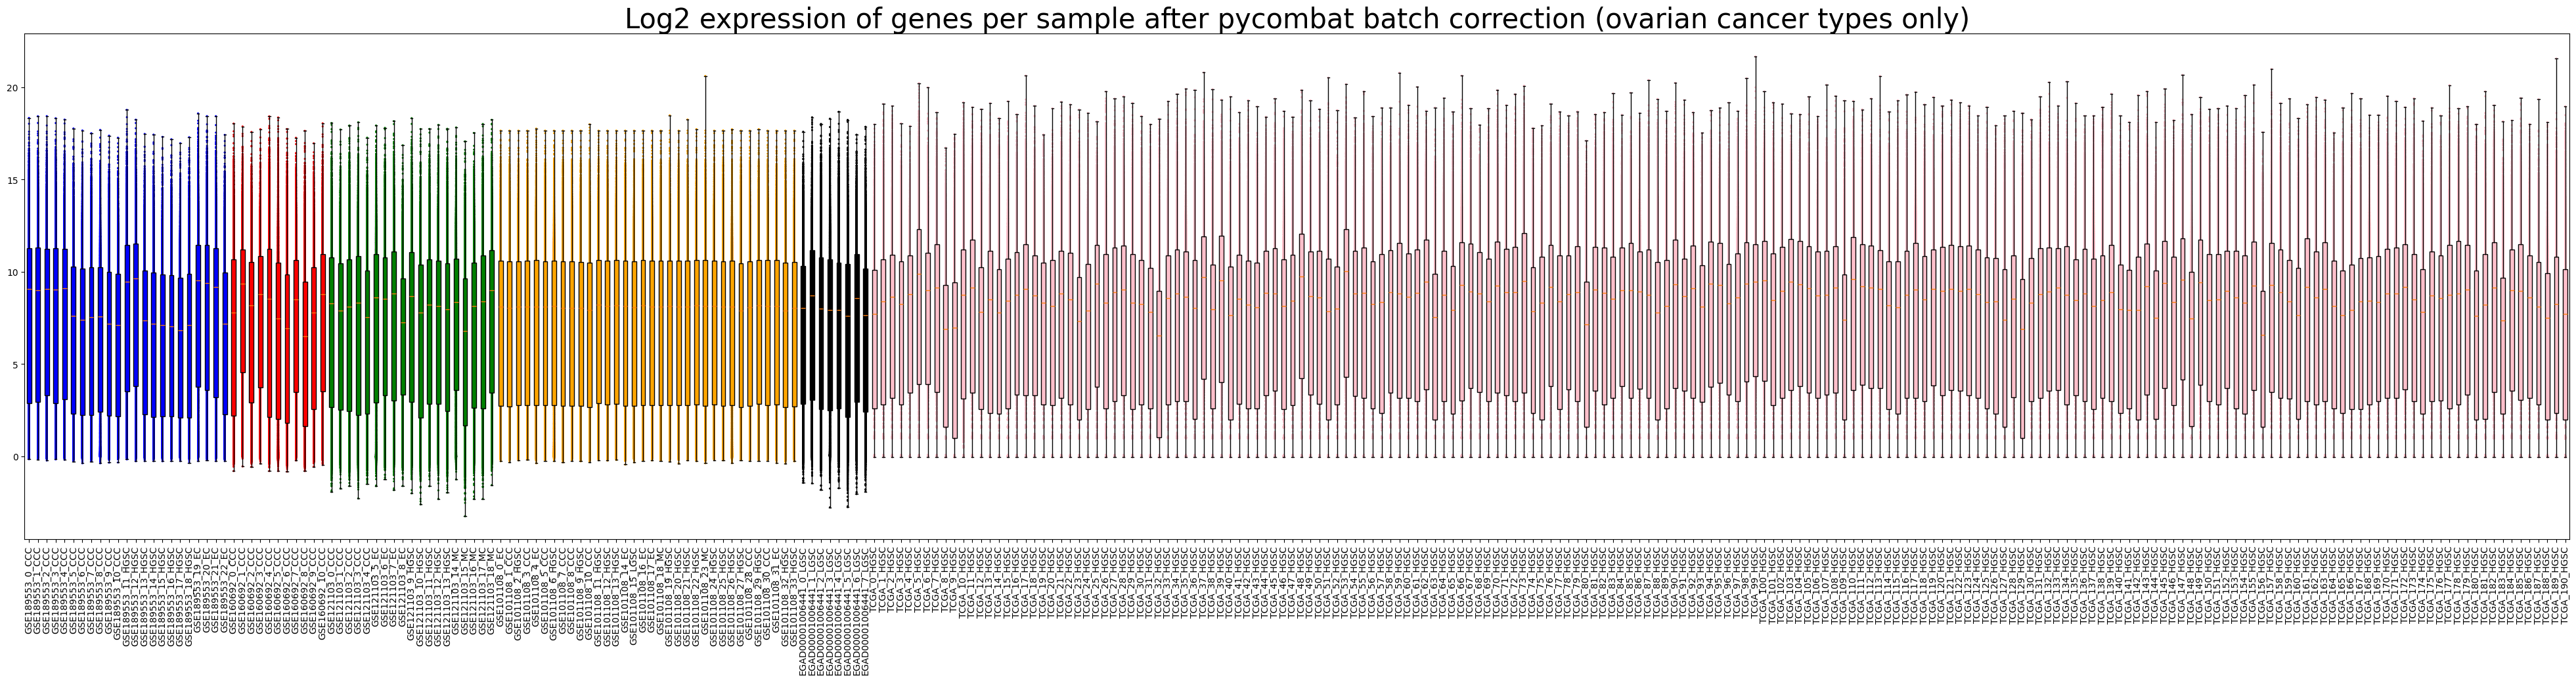

In [25]:
boxplot(log2_expression_corrected_ov_only, "Log2 expression of genes per sample after pycombat batch correction (ovarian cancer types only)")

### UMAP after pycombat correction

In [ ]:
plot_umap(log2_expression_corrected, metadata_with_tcga_all_cancer_types, "UMAP of log2 expression of genes per sample after pycombat batch correction")

sample_id,GSE189553_0_CCC,GSE189553_1_CCC,GSE189553_2_CCC,GSE189553_3_CCC,GSE189553_4_CCC,GSE189553_5_CCC,GSE189553_6_CCC,GSE189553_7_CCC,GSE189553_8_CCC,GSE189553_9_CCC,...,TCGA_181_HGSC,TCGA_182_HGSC,TCGA_183_HGSC,TCGA_184_HGSC,TCGA_185_HGSC,TCGA_186_HGSC,TCGA_187_HGSC,TCGA_188_HGSC,TCGA_189_HGSC,TCGA_190_HGSC
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,4.642651,6.855779,6.789891,4.984279,6.555488,4.087719,3.030799,4.085724,3.637172,4.236425,...,3.890370,4.305039,3.790922,6.535718,6.131235,4.889482,3.305926,3.790922,4.626681,3.790922
A1BG-AS1,7.284288,7.721349,7.439436,6.746961,7.742398,5.726692,5.499831,5.476513,5.237487,5.387428,...,6.660238,6.022943,4.998243,8.055051,7.850226,6.945190,5.208174,2.993679,4.697999,3.579976
A2M,15.147553,15.110762,15.145383,15.335212,14.907901,14.058586,13.708784,13.825416,13.736122,13.473438,...,13.556078,14.023961,12.218531,14.057147,13.501159,13.831187,14.251369,12.936353,13.306444,14.956738
A2M-AS1,5.921420,6.103093,6.359147,6.304199,5.665365,5.106153,4.925754,5.205138,5.037487,4.867091,...,5.619333,8.963562,6.732058,6.745375,6.042210,8.118834,8.149254,5.730533,5.757046,7.235325
A2ML1,6.828482,6.828482,6.828482,6.584977,7.391905,3.785894,4.436681,3.816568,4.119690,3.801306,...,8.684754,7.992563,2.562204,9.446148,9.051009,7.667583,4.141901,3.296721,3.879740,8.500479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,10.980697,11.010946,10.930750,10.891639,10.950213,10.166820,10.137708,10.262759,10.210726,10.089671,...,10.764460,12.112375,9.646975,11.157005,11.199239,11.359781,10.562087,9.940254,9.989731,9.615063
ZYG11A,8.193598,8.183452,6.410251,7.221145,9.174175,3.890396,3.213038,2.551296,2.615720,3.339712,...,7.947699,6.999863,4.373526,8.869670,4.303236,5.623298,4.787977,4.735584,6.517336,2.983174
ZYG11B,11.579841,11.741462,11.545983,11.681341,11.628848,10.328017,10.231054,10.308541,10.384271,10.185426,...,11.044443,11.870732,9.956891,12.312780,11.200497,10.541081,10.631762,9.835520,10.800283,10.299936


,dataset_name,original_sample_name,type,non-ovarian_cancer_type
sample_id,,,,
GSE189553_0_CCC,GSE189553,CCC_1,CCC,NaN
GSE189553_1_CCC,GSE189553,CCC_2,CCC,NaN
GSE189553_2_CCC,GSE189553,CCC_3,CCC,NaN
GSE189553_3_CCC,GSE189553,CCC_4,CCC,NaN
GSE189553_4_CCC,GSE189553,CCC_5,CCC,NaN
...,...,...,...,...
TCGA_10047_non_ovarian,TCGA,TCGA-UF-A7JT,non_ovarian,HNSC
TCGA_10048_non_ovarian,TCGA,TCGA-UF-A7JV,non_ovarian,HNSC
TCGA_10049_non_ovarian,TCGA,TCGA-UP-A6WW,non_ovarian,HNSC


,dataset_name,original_sample_name,type,non-ovarian_cancer_type
sample_id,,,,
GSE189553_0_CCC,GSE189553,CCC_1,CCC,NaN
GSE189553_1_CCC,GSE189553,CCC_2,CCC,NaN
GSE189553_2_CCC,GSE189553,CCC_3,CCC,NaN
GSE189553_3_CCC,GSE189553,CCC_4,CCC,NaN
GSE189553_4_CCC,GSE189553,CCC_5,CCC,NaN
...,...,...,...,...
TCGA_186_HGSC,TCGA,TCGA-59-2352,HGSC,NaN
TCGA_187_HGSC,TCGA,TCGA-61-2102,HGSC,NaN
TCGA_188_HGSC,TCGA,TCGA-13-0804,HGSC,NaN


/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_59391/3100638957.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)


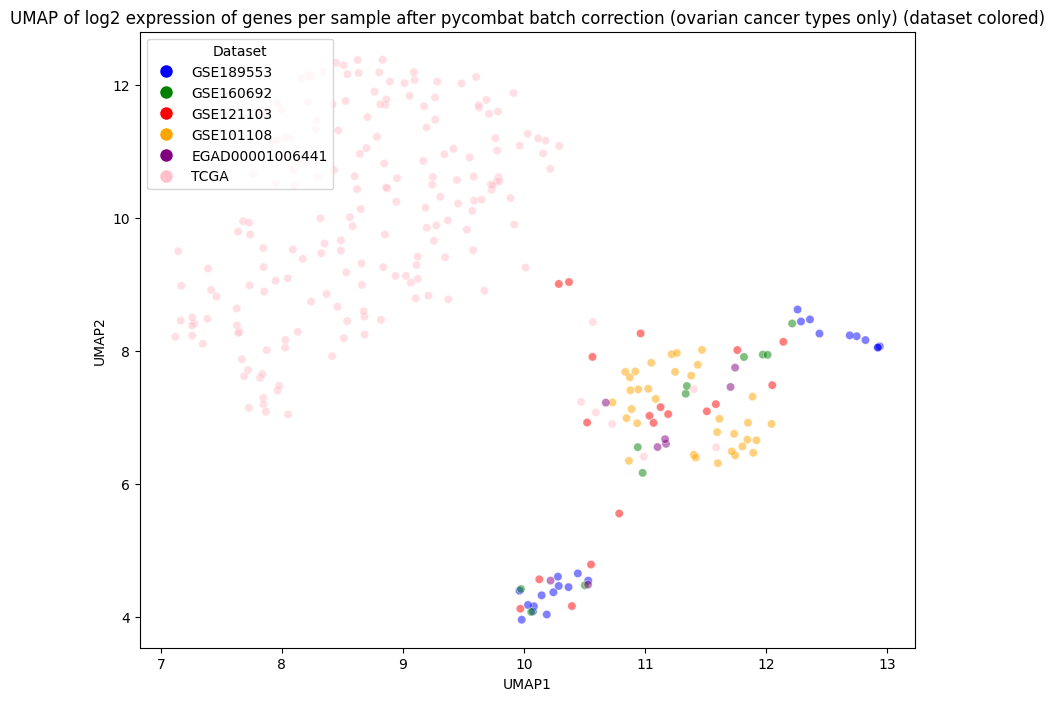

/var/folders/nn/pb4b1kzx12vbp6sgl69b77rw0000gp/T/ipykernel_59391/3100638957.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['colors'], cmap='Spectral', alpha=0.5, edgecolor='w', linewidth=0.5)


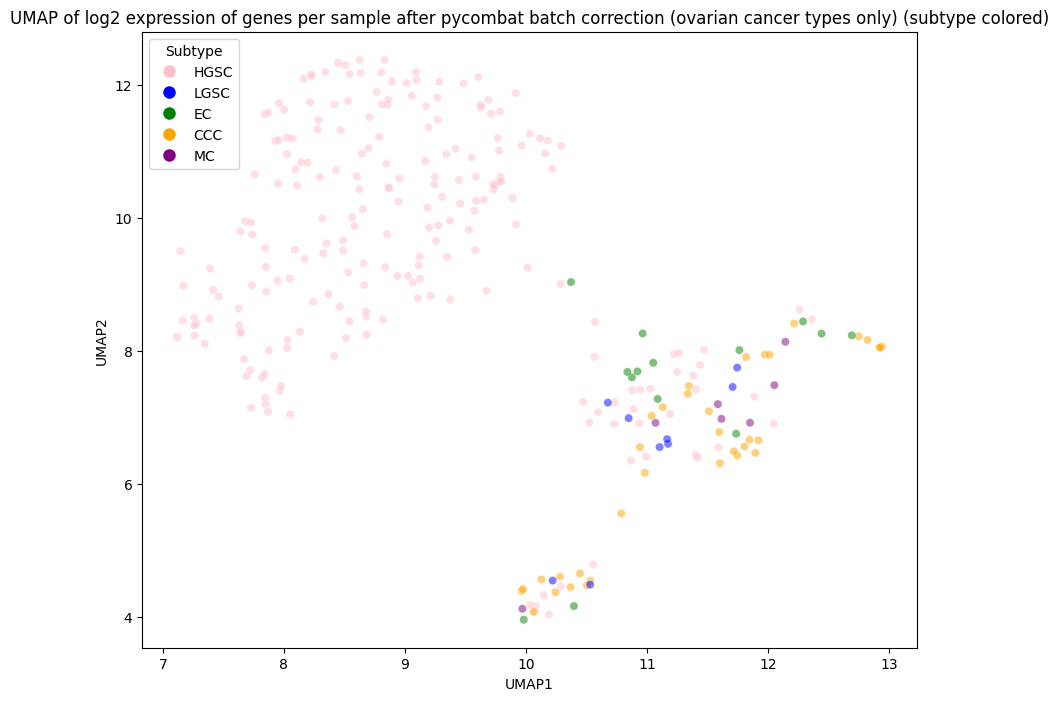

In [29]:
display(log2_expression_corrected_ov_only)
display(metadata_with_tcga_all_cancer_types)
display(metadata_with_tcga_all_cancer_types[metadata_with_tcga_all_cancer_types["type"] != "non_ovarian"])

plot_umap(log2_expression_corrected_ov_only, metadata_with_tcga_all_cancer_types[metadata_with_tcga_all_cancer_types["type"] != "non_ovarian"], "UMAP of log2 expression of genes per sample after pycombat batch correction (ovarian cancer types only)")